# Assignment
In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

Load the houseprices data from Thinkful's database.
Split your data into train and test sets.
Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
Is the performance of your model satisfactory? Why?
Try to improve your model in terms of predictive performance by adding or removing some variables.
Please submit a link your work notebook. This is not a graded checkpoint, but you should discuss your solutions with your mentor. Also, when you're done, compare your work to this example solution.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV


In [74]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [75]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [76]:
houseprices_df1=houseprices_df #make a copy

In [77]:
houseprices_df1 = pd.concat([houseprices_df1,pd.get_dummies(houseprices_df1.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df1 = pd.concat([houseprices_df1,pd.get_dummies(houseprices_df1.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houseprices_df1.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df1.street, prefix="street", drop_first=True).columns)


# Build your initial model using these features and estimate the parameters using OLS.

In [78]:
X = houseprices_df1[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_RL', 'lotarea', 'overallcond'] + dummy_column_names]
y = houseprices_df1.saleprice

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [80]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     361.5
Date:                Sun, 04 Aug 2019   Prob (F-statistic):               0.00
Time:                        11:57:05   Log-Likelihood:                -13955.
No. Observations:                1168   AIC:                         2.793e+04
Df Residuals:                    1156   BIC:                         2.799e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.366e+05   2.11e+04     -6.482      

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


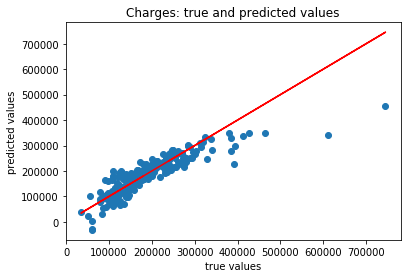

Mean absolute error of the prediction is: 24748.48678522524
Mean squared error of the prediction is: 1535699033.5341725
Root mean squared error of the prediction is: 39187.996038763864
Mean absolute percentage error of the prediction is: 15.133802730340918


In [91]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [82]:
#This model is better because the metrics are lower. There are some outliers which can affect our values. It might be 
#good to eliminate them and try again. 

In [83]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 714114172263.9286, tolerance: 583907568.4905311
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634433930521.1235, tolerance: 615364382.1733792
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 719081814659.0286, tolerance: 615364382.1733792
  tol, rng, random, positive)


Best alpha value is: 100.0
R-squared of the model in training set is: 0.7745875668740225
-----Test set statistics-----
R-squared of the model in test set is: 0.7707783137138297
Mean absolute error of the prediction is: 24825.95541358898
Mean squared error of the prediction is: 1538926570.2315495
Root mean squared error of the prediction is: 39229.154594912565
Mean absolute percentage error of the prediction is: 15.279336221235774


In [84]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**37) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0016183407463286061
Mean absolute error of the prediction is: 58023.64411709514
Mean squared error of the prediction is: 6724569139.943377
Root mean squared error of the prediction is: 82003.47029207592
Mean absolute percentage error of the prediction is: 36.65964810134902


In [96]:
ridge_cv = RidgeCV(alphas= alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.35404e-22): result may not be accurate.
  overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.32835e-22): result may not be accurate.
  overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.28918e-22): result may not be accurate.
  overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.15359e-21): result may not be accurate.
  overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147:

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7746916875611195
-----Test set statistics-----
R-squared of the model in test set is: 0.7712307948047283
Mean absolute error of the prediction is: 24781.729804613846
Mean squared error of the prediction is: 1535888746.0858793
Root mean squared error of the prediction is: 39190.41650819597
Mean absolute percentage error of the prediction is: 15.218850951734739


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [89]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.7747273205513929
-----Test set statistics-----
R-squared of the model in test set is: 0.7710992818389115
Mean absolute error of the prediction is: 24786.04086877725
Mean squared error of the prediction is: 1536771685.2209344
Root mean squared error of the prediction is: 39201.67962244646
Mean absolute percentage error of the prediction is: 15.213884513669992


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 602990590498.6276, tolerance: 569928608.1101847
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 602755724618.041, tolerance: 569928608.1101847
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 602724140479.8269, tolerance: 569928608.1101847
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=42)
kf.get_n_splits(X,Y)

big_list = []
for train_index, test_index in kf.split(X):
    big_list.append({'X_train': np.take(X, train_index, axis=0),
                     'X_test': np.take(X, test_index, axis=0),
                     'Y_train': np.take(Y, train_index, axis=0),
                     'Y_test': np.take(Y, test_index, axis=0)})

 
reg = LinearRegression().fit(X,Y)

cross_val_score(reg, X,Y, cv=kf)